<a href="https://colab.research.google.com/github/allanrfs3/ML-Sipetta-Similarity-BERT/blob/main/ml_similarity_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PySastrawi
import re
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

import string
string.punctuation
import csv

import numpy as np
import joblib
import pickle
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset Penyakit Tanaman.csv to Dataset Penyakit Tanaman.csv


In [ ]:
data = pd.read_csv('/content/Dataset Penyakit Tanaman.csv')
data.head()

,no_penyakit,nama_penyakit,deskripsi_penyakit,NOTES
0,AP01,Busuk daun jamur,Daun bercak basah titik kecil berwarna gelap. ...,AP : Penyakit Andewi\nSP : Penyakit Selada\nWP...
1,AP02,Karat,muncul bercak karat. titik kecil berwarna oran...,NaN
2,SP01,Busuk daun,tulang daun terjadi bercak bersudut. berwarna ...,NaN
3,SP02,Busuk Rhizoctonia,"Tanaman mendekati masak, daun tua di atas tana...",NaN
4,SP03,Bercak daun,gejala tampak sebagai bercak kecil kebasahan p...,NaN


In [ ]:
data = pd.read_csv('Dataset Penyakit Tanaman.csv')
data = data.drop(["no_penyakit", 'NOTES'], axis=1)
data.head()

,nama_penyakit,deskripsi_penyakit
0,Busuk daun jamur,Daun bercak basah titik kecil berwarna gelap. ...
1,Karat,muncul bercak karat. titik kecil berwarna oran...
2,Busuk daun,tulang daun terjadi bercak bersudut. berwarna ...
3,Busuk Rhizoctonia,"Tanaman mendekati masak, daun tua di atas tana..."
4,Bercak daun,gejala tampak sebagai bercak kecil kebasahan p...


In [ ]:
#from dataclasses import dataclass
#from six import text_type
import pandas as pd
class preprocessing:
    def __init__(self, data):   #membaca data
        self.data = pd.read_csv(data)

    def load_dataset(self):    #menampilkan data
        read = self.data['deskripsi_penyakit']
        return read

    def case_folding(self):   #mengubah data menjadi huruf kecil
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].str.lower()

    def remove_pattern(self, pattern_regex):    #menghapus karakter tertentu
      def remove_pattern(pattern_regex):
        r = re.findall(pattern_regex, self)
        for i in r:
            description = re.sub(i, ' ', self)
        return self
        self.data['deskripsi_penyakit'] = np.vectorize(remove_pattern)(self.data['deskripsi_penyakit'], " *RT* | *@[\w]* ")

    def remove_1(self, text):  #menghapus karakter tertentu
      def remove(text):
        text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lambda x: remove(x))

    def remove_2(self,text):
        def remove(text):
            #remove old style retweet text "RT"
            tweet = re.sub(r'^RT[\s]+', '', text)

            #remove old style retweet text "RT"
            tweet = re.sub(r'^RT[\s]+', '', text)

            #remove hastag
            #only removing the hash # sign from the word
            tweet = re.sub(r'#', '', text)

            #remove angka
            tweet = re.sub('[0-9]+', '', text)
            return tweet
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lambda x: remove(x))

    def tokenization(self,text):   #memisahkan teks menjadi per kata
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        def tokenize(text):
          text = re.split('\W+', text)
          return text
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(tokenize)

    def stemming(self,text):   #menjadikan kata tokenize menjadi kata dasar
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()

        def stemmed_wrapper(term):
            return stemmer.stem(term)
        term_dict= {}

        for document in self.data['deskripsi_penyakit']:
            for term in document:
                if term not in term_dict:
                    term_dict[term] = ' '

        for term in term_dict:
            term_dict[term] = stemmed_wrapper(term)

        def get_stemmed_term(document):
            return [term_dict[term] for term in document]

        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(get_stemmed_term)

    def lemmatizer(self, text):   #akar kata
      def lemma(text):
        wn = nltk.WordNetLemmatizer()
        text = [wn.lemmatize(word) for word in text]
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lemma)

    def remove_punct(self, text):   #menghapus katakter
      def remove_punct(text):
        text = " ".join([char for char in text if char not in string.punctuation])
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(remove_punct)

    def save(self):   #menyimpan data
        self.data.to_csv('/content/Dataset Penyakit Tanaman 2.csv', encoding = 'utf8', index = False)

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Dataset Penyakit Tanaman.csv')
dataset = preprocessing(data='Dataset Penyakit Tanaman.csv') #filenya allan manggilnya gini, kalau pakai punyamu error:"(
cf = dataset.case_folding()
rp = dataset.remove_pattern(dataset)
r = dataset.remove_1(rp)
r2 = dataset.remove_2(r)
token = dataset.tokenization(r2)
st = dataset.stemming(token)
lz = dataset.lemmatizer(st)
rv = dataset.remove_punct(lz)
simpan = dataset.save()

In [ ]:
data = pd.read_csv('/content/Dataset Penyakit Tanaman 2.csv')
data = data.drop(["no_penyakit", 'NOTES'], axis=1)
data.head()

,nama_penyakit,deskripsi_penyakit
0,Busuk daun jamur,daun bercak basah titik kecil warna gelap daun...
1,Karat,muncul bercak karat titik kecil warna oranye a...
2,Busuk daun,tulang daun jadi bercak sudut warna hijau muda...
3,Busuk Rhizoctonia,tanam dekat masak daun tua di atas tanah infek...
4,Bercak daun,gejala tampak bagai bercak kecil basah pada te...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = list(data["deskripsi_penyakit"])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print('Shape X :', X.shape)

data_vector = pd.DataFrame(X.todense(),
              columns=vectorizer.get_feature_names_out(),
              index=data.nama_penyakit).sample(22, axis=1).sample(10, axis=0)
print(data_vector)

from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(X,X)
pd.DataFrame(cos_sim)

Shape X : (30, 476)
                        hambat  pengaruh    bentuk  boron  oomycete     tanah  \
nama_penyakit                                                                   
Busuk hitam                0.0  0.000000  0.092591    0.0       0.0  0.000000   
Antraknosa                 0.0  0.000000  0.099036    0.0       0.0  0.000000   
Hawar Daun                 0.0  0.000000  0.000000    0.0       0.0  0.000000   
Busuk bakteri              0.0  0.127825  0.000000    0.0       0.0  0.000000   
Busuk Leher Batang         0.0  0.000000  0.000000    0.0       0.0  0.054197   
Ulat perusak daun          0.0  0.000000  0.000000    0.0       0.0  0.000000   
Busuk daun Choanephora     0.0  0.000000  0.092471    0.0       0.0  0.000000   
Busuk bibit                0.0  0.000000  0.000000    0.0       0.0  0.102331   
Bercak daun cercospora     0.0  0.000000  0.000000    0.0       0.0  0.000000   
Busuk Putih                0.0  0.000000  0.057981    0.0       0.0  0.065771   

       

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.324191,0.203036,0.122750,0.239818,0.310940,0.368848,0.157305,0.370327,0.185122,...,0.280221,0.322457,0.170645,0.197659,0.248747,0.258456,0.243798,0.207500,0.107403,0.251309
1,0.324191,1.000000,0.169258,0.111859,0.192717,0.141040,0.247798,0.096640,0.226907,0.170626,...,0.145995,0.113786,0.077063,0.086354,0.096584,0.197714,0.204010,0.161798,0.102192,0.193525
2,0.203036,0.169258,1.000000,0.183014,0.183373,0.155877,0.226693,0.205367,0.122533,0.098391,...,0.193008,0.261865,0.088842,0.104357,0.170053,0.165385,0.188117,0.118697,0.090609,0.198976
3,0.122750,0.111859,0.183014,1.000000,0.153403,0.170443,0.156279,0.098449,0.189392,0.119150,...,0.211186,0.217693,0.156393,0.166502,0.210983,0.153956,0.195795,0.200855,0.142393,0.179793
4,0.239818,0.192717,0.183373,0.153403,1.000000,0.155288,0.261990,0.230660,0.185299,0.117298,...,0.334549,0.269606,0.144448,0.136396,0.177592,0.306344,0.224056,0.288846,0.132427,0.285386
5,0.310940,0.141040,0.155877,0.170443,0.155288,1.000000,0.232186,0.191818,0.292069,0.068421,...,0.157948,0.296808,0.212859,0.142846,0.183208,0.239975,0.206816,0.195580,0.133709,0.202141
6,0.368848,0.247798,0.226693,0.156279,0.261990,0.232186,1.000000,0.232448,0.358696,0.206397,...,0.270405,0.296676,0.225665,0.174512,0.193715,0.305748,0.217790,0.288138,0.155865,0.278236
7,0.157305,0.096640,0.205367,0.098449,0.230660,0.191818,0.232448,1.000000,0.194421,0.176048,...,0.281365,0.207908,0.152785,0.113186,0.165738,0.242268,0.252418,0.174879,0.146169,0.225291
8,0.370327,0.226907,0.122533,0.189392,0.185299,0.292069,0.358696,0.194421,1.000000,0.243150,...,0.302758,0.378798,0.357317,0.292472,0.312375,0.339525,0.312311,0.376791,0.238333,0.228440
9,0.185122,0.170626,0.098391,0.119150,0.117298,0.068421,0.206397,0.176048,0.243150,1.000000,...,0.179901,0.208708,0.166427,0.152112,0.192740,0.212111,0.249854,0.190824,0.163875,0.152771


In [ ]:
cos_sim_data = pd.DataFrame(cos_sim, index=data['nama_penyakit'], columns=data['nama_penyakit'])
print('Shape:', cos_sim_data.shape)

cos_sim_data.sample(5, axis=1).sample(10, axis=0)

Shape: (30, 30)


nama_penyakit,Bercak daun stemphylium,Ulat tanah,Busuk hati/jantung sawi,Busuk Umbi Fusarium,Busuk Putih
nama_penyakit,,,,,
Busuk Umbi Fusarium,0.113186,0.121884,0.239720,1.000000,0.359806
Busuk bibit,0.152785,0.141329,0.320872,0.355579,0.278972
Bercak daun,0.230660,0.063152,0.361906,0.136396,0.177592
Ulat tanah,0.105078,1.000000,0.166466,0.121884,0.120887
Bercak daun septoria,0.225291,0.104440,0.272326,0.211018,0.300192
Busuk hati/jantung sawi,0.255161,0.166466,1.000000,0.239720,0.346001
Busuk daun abu,0.191818,0.133429,0.216163,0.142846,0.183208
Busuk daun,0.205367,0.081584,0.201983,0.104357,0.170053
Busuk hitam,0.183194,0.132953,0.450685,0.162475,0.261187


In [ ]:
def penyakit_recommendations(nama_penyakit, similarity_data=cos_sim_data, items=data[['nama_penyakit', 'deskripsi_penyakit']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_penyakit].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_penyakit, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
from difflib import SequenceMatcher

# Fungsi untuk menghitung similarity menggunakan cosine similarity
def calculate_cosine_similarity(input_text, corpus):
    vectorizer = TfidfVectorizer()
    corpus.append(input_text)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    similarity_scores = similarity_matrix[-1, :-1]
    return similarity_scores

# Fungsi untuk menghitung similarity menggunakan Sequence Matcher (untuk perbandingan sederhana)
def calculate_sequence_similarity(input_text, corpus):
    similarity_scores = [SequenceMatcher(None, input_text, text).ratio() for text in corpus]
    return similarity_scores

# Inputan pengguna
user_input = input("Masukkan teks yang ingin dibandingkan: ")

# Hitung similarity menggunakan cosine similarity
cosine_similarity_scores = calculate_cosine_similarity(user_input, data['deskripsi_penyakit'].str.lower().tolist())*100

# Hitung similarity menggunakan Sequence Matcher
sequence_similarity_scores = calculate_sequence_similarity(user_input, data['deskripsi_penyakit'].tolist())

# Tambahkan hasil similarity ke DataFrame
data['cosine_similarity'] = cosine_similarity_scores
data['sequence_similarity'] = sequence_similarity_scores

# Temukan teks dengan cosine similarity paling besar
max_cosine_similarity_index = data['cosine_similarity'].idxmax()
max_cosine_similarity_penyakit = data.loc[max_cosine_similarity_index, 'nama_penyakit']
max_cosine_similarity_text = data.loc[max_cosine_similarity_index, 'deskripsi_penyakit']
max_cosine_similarity_value = data.loc[max_cosine_similarity_index, 'cosine_similarity']

# Temukan teks dengan sequence similarity paling besar
max_sequence_similarity_index = data['sequence_similarity'].idxmax()
max_sequence_similarity_penyakit = data.loc[max_sequence_similarity_index, 'nama_penyakit']
max_sequence_similarity_text = data.loc[max_sequence_similarity_index, 'deskripsi_penyakit']
max_sequence_similarity_value = data.loc[max_sequence_similarity_index, 'sequence_similarity']

#print("\nTeks dengan Cosine Similarity Paling Besar:")
print(f"Nama Penyakit: {max_cosine_similarity_penyakit}")
print(f"Text: {max_cosine_similarity_text}")
print(f"Cosine Similarity: {max_cosine_similarity_value}")

model.save('cosine_similarity_model.h5')


Masukkan teks yang ingin dibandingkan: Sawi saya terkena busuk hati atau jantung. Bagian dalam tanaman tampak terinfeksi dan pertumbuhan tanaman terhambat. Apakah ada solusi untuk penyakit ini?
Nama Penyakit: Leaf miner
Text: leaf miner lorong pada daun jejak makan ulat daun ering daun warna kuning coklat dapat larva rayap di dalam turun kualitas daun telur letak dalam daun kelembaban dan suhu tentu rusa estetika sawi turun hasil panen drastis rentan hadap sakit
Cosine Similarity: 6.726614965445939


## Deploy ke Aplikasi

In [ ]:
import keras
import tensorflow as tf
import transformers

# Load the model
model_cos_sim = tf.keras.models.load_model('cosine_similarity_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_cos_sim)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('cosine_similarity_model.tflite', 'wb') as f:
    f.write(tflite_model)


## BERT


In [1]:
!pip install tokenization
import numpy as np
import pandas as pd
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

In [3]:
train_data = pd.read_csv('/content/Copy of Dataset Tingkat2.csv')
test_data = pd.read_csv('/content/Gejala2.csv')

In [4]:
test_data = test_data.drop(['nama_penyakit'], axis=1)
test_data = test_data.iloc[:, 0:5]
test_data.head()

,tipe_gejala
0,Tanaman saya mengalami masalah busuk hitam. Bu...
1,Daun tanaman saya terinfeksi busuk basah. Saya...
2,Sawi saya terkena busuk hati atau jantung. Bag...
3,Tanaman saya menunjukkan gejala mosaik. Daunny...
4,Tanaman saya mengalami busuk bakteri. Bagian-b...


In [5]:
label = preprocessing.LabelEncoder()
y = label.fit_transform(train_data['tingkat_keparahan'])
y = to_categorical(y)
print(y)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [6]:
labels = label.classes_
print(labels)

['Tingkat Parah' 'Tingkat Ringan' 'Tingkat Sedang']


In [7]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=False)

In [8]:
from transformers import BertTokenizer

# Instantiate the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

def bert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [15]:
def build_model(bert_layer, max_len=100):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]

    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(3, activation='softmax')(lay)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
max_len = 100
train_input = bert_encode(train_data.deskripsi_penyakit.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.tipe_gejala.values, tokenizer, max_len=max_len)
train_labels = y

In [17]:
model = build_model(bert_layer, max_len=max_len)
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 100)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 768),                1094822   ['input_word_ids[0][0]',

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_bert_3_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = model.fit(
    train_input, train_labels,
    validation_split=0.3,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.3810
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to model_bert_3_1.h5
1/1 [==============================] - 28s 28s/step - loss: 1.1869 - accuracy: 0.3810 - val_loss: 1.1118 - val_accuracy: 0.4444
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.1113 - accuracy: 0.2381
Epoch 2: val_accuracy did not improve from 0.44444
1/1 [==============================] - 13s 13s/step - loss: 1.1113 - accuracy: 0.2381 - val_loss: 1.1215 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.2047 - accuracy: 0.2857
Epoch 3: val_accuracy did not improve from 0.44444
1/1 [==============================] - 10s 10s/step - loss: 1.2047 - accuracy: 0.2857 - val_loss: 1.1235 - val_accuracy: 0.2222
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.3810
Epoch 4: val_accuracy did not improve from 0.44444
1/1 [===

In [19]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {final_loss:.4f}')
print(f'Final Training Accuracy: {final_accuracy:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')


Final Training Loss: 1.1630
Final Training Accuracy: 0.3333
Final Validation Loss: 1.0850
Final Validation Accuracy: 0.3333


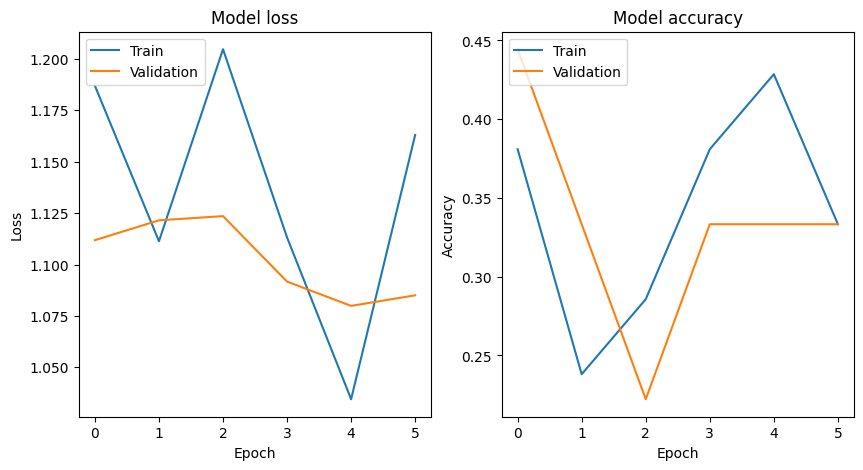

In [22]:
import matplotlib.pyplot as plt
# Plot training & validation loss values - model_trial1_new.h5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set(title='Model loss', xlabel='Epoch', ylabel='Loss')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
ax[1].set(title='Model accuracy', xlabel='Epoch', ylabel='Accuracy')
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['Train', 'Validation'], loc='upper left')

## Deploy ke Aplikasi

In [21]:
import keras
import tensorflow as tf
import transformers

# Load the model
model_bert= tf.keras.models.load_model('model_bert_3_1.h5', custom_objects={'KerasLayer': bert_layer})

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_bert)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model_bert_3_1.tflite', 'wb') as f:
    f.write(tflite_model)
